In [136]:
# === Standard Python Libraries ===
import os
import shutil
import time
from collections import defaultdict

# === Data Handling and Math ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# === EMA Workbench Core ===
from ema_workbench import (
    Model, Policy, Scenario,
    MultiprocessingEvaluator, ema_logging,
    Constraint
)
from ema_workbench.em_framework.evaluators import (
    BaseEvaluator, perform_experiments
)
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, EpsilonProgress, EpsNSGAII,
    HyperVolume, epsilon_nondominated, to_problem
)
from ema_workbench.em_framework.outcomes import ScalarOutcome
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# === EMA Workbench Analysis Tools ===
from ema_workbench.analysis import (
    feature_scoring, parcoords, pairs_plotting,
    prim, dimensional_stacking
)

# === Other Useful Pandas Utilities ===
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

# === Custom Problem Formulation ===
from problem_formulation import get_model_for_problem_formulation

# === SALib for Global Sensitivity Analysis ===
from SALib.analyze import sobol


def get_do_nothing_dict():
    return {l.name: 0 for l in model.levers}


# First iteration of MORDM with the reference scenario

This section presents the first iteration of the Multi-Objective Robust Decision Making (MORDM) process, conducted under a single reference scenario. The goal is to explore the trade-offs between key objectives and identify a diverse set of Pareto-optimal policies. Following the optimization, an uncertainty analysis is performed using a regret matrix. This matrix quantifies how much worse each policy performs compared to the best-performing policy in each scenario, helping to evaluate the robustness of the solutions under varying future conditions. Also all the analysis are supported with visuals that are also made in this section


In [137]:
# === RfR Constraint Setup for EMA Workbench ===
# This constraint ensures that at most one Room for the River (RfR) project
# can be implemented per spatial area (e.g., dike ring) across all planning steps.

# --- STEP 1: Define Lever Names Used in the Constraint ---
# Make sure these lever names exactly match the ones used in your model's lever definitions.
# The example below assumes 5 areas (e.g., 5 dike rings), and 3 time steps (0, 1, 2) per area.

rfr_lever_names = [f"{area}_RfR {i}" for area in range(5) for i in range(3)]
# Example result: ['0_RfR 0', '0_RfR 1', '0_RfR 2', ..., '4_RfR 2']

# --- STEP 2: Define the Constraint Function ---
# This function calculates a violation value based on the policy configuration.
# If more than 1 RfR project is selected within a single area, the excess is treated as a violation.

def max_one_rfr_total(*args):
    total = float(np.sum(args))  # Not strictly required, but helps ensure inputs are numerical scalars
    violation = 0

    # Group every 3 values (one per planning step) for each area
    for i in range(0, len(args), 3):
        group_total = float(np.sum(args[i:i+3]))  # sum of RfR values for one area
        if group_total > 1:
            # If more than 1 project is selected in the same area, add the excess to the violation
            violation += group_total - 1

    return violation  # Value must be ≥ 0 to be feasible; >0 = constraint violation

# --- STEP 3: Wrap the Constraint Function as a Constraint Object ---
# This constraint can now be passed to the `evaluator.optimize(..., constraints=[...])` method

max_one_rfr_constraint = Constraint(
    "max_one_rfr_total",         # Name of the constraint (for debugging or display)
    function=max_one_rfr_total,  # The function defined above
    parameter_names=rfr_lever_names   # List of levers this constraint depends on
)

In [138]:
#Start with running baseline scenario
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        baseline = Policy("do_nothing", **get_do_nothing_dict())
        policies = [baseline]

        results = evaluator.perform_experiments(scenarios=50, policies=policies)
        baseline_experiments, baseline_outcomes = results


[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments

100%|██████████████████████████████████████████| 50/50 [00:08<00:00,  5.82it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [139]:
# Here the MORDM is run and shown

if __name__ == "__main__":

    # === Load model for Problem Formulation 3 ===
    # This version includes a focus on HRI and Room for the River measures.
    model, planning_steps = get_model_for_problem_formulation(3)

    # === Define reference scenario using median values of uncertainties ===
    # These values represent an "average" scenario for the optimization process.
    reference_values = {
        "Bmax": 175,                     # Max breach width (median)
        "Brate": 1.5,                    # Breach growth rate (median)
        "pfail": 0.5,                    # Fragility curve failure probability
        "discount rate 0": 3.5,          # Economic discount rate per planning step
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4         # Median flood wave ID
    }

    # === Map uncertainties to their values for the reference scenario ===
    scen1 = {}
    for key in model.uncertainties:
        name_split = key.name.split("_")
        if len(name_split) == 1:
            scen1[key.name] = reference_values[key.name]
        else:
            scen1[key.name] = reference_values[name_split[1]]

    ref_scenario = Scenario("reference", **scen1)

    # === Define convergence metrics ===
    convergence_metrics = [EpsilonProgress()]  # Track progress over time

    # === Define epsilon values (resolution of Pareto front) ===
    epsilons = [0.01] * len(model.outcomes)  # One for each outcome

    # === Optimization settings ===
    nfe = 150  # Number of function evaluations (change to e.g. 15000 for full run)

    # === Perform multi-objective optimization over policy levers ===
    # Use evolutionary algorithm (e.g. ε-NSGAII) with a hard constraint
    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilons,
            convergence=convergence_metrics,
            constraints=[max_one_rfr_constraint],  # Custom constraint on RfR levers
            reference=ref_scenario  # Reference scenario to guide optimization
        )

[MainProcess/INFO] pool started with 8 workers

  0%|                                                  | 0/150 [00:00<?, ?it/s]INFO | EpsNSGAII starting

 67%|██████████████████████████▋             | 100/150 [00:14<00:07,  6.99it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:28.540651

200it [00:28,  7.01it/s]                                                       
[MainProcess/INFO] optimization completed, found 6 solutions
[MainProcess/INFO] terminating pool


In [140]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,1,0,0,0,0,0,0,0,0,0,...,6,1,3,1,1,2.061151e+08,0.000932,0.30,340700000.0,621.986237
1,0,0,0,0,1,0,0,0,1,0,...,7,1,7,3,0,1.466041e+08,0.017850,0.96,625800000.0,0.000000
2,0,0,0,0,0,0,1,0,0,1,...,1,4,5,9,8,2.085918e+08,0.002506,0.39,151900000.0,0.000000
3,1,0,0,1,0,0,0,1,0,0,...,5,7,10,7,3,1.160050e+08,0.000000,1.05,589200000.0,245.667899
4,0,1,0,1,0,0,0,0,0,0,...,3,10,5,5,5,2.125611e+08,0.000000,1.03,558500000.0,0.000000
5,1,0,0,0,0,0,0,1,0,0,...,4,7,4,3,5,1.631804e+08,0.000000,0.72,371400000.0,517.245420


## Convergence analysis

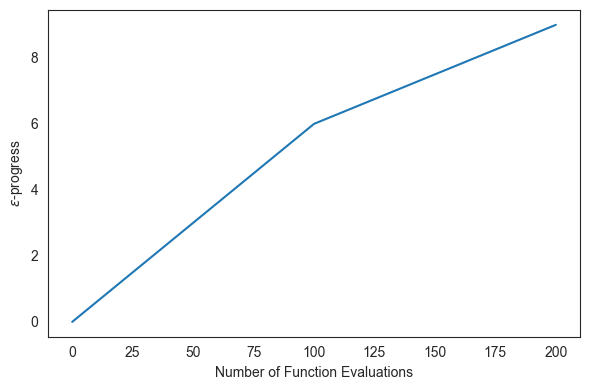

In [141]:
# === Convergence Plot: ε-Progress Over Number of Function Evaluations ===

# Create a figure and axis object with defined size
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot epsilon-progress (how the Pareto front improves over time)
ax1.plot(convergence.nfe, convergence.epsilon_progress)

# Label the axes
ax1.set_ylabel(r'$\epsilon$-progress')  # LaTeX formatting for epsilon
ax1.set_xlabel('Number of Function Evaluations')

# Save the figure to disk
plt.savefig("convergence enkel MORDM.png", dpi=300, bbox_inches='tight')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

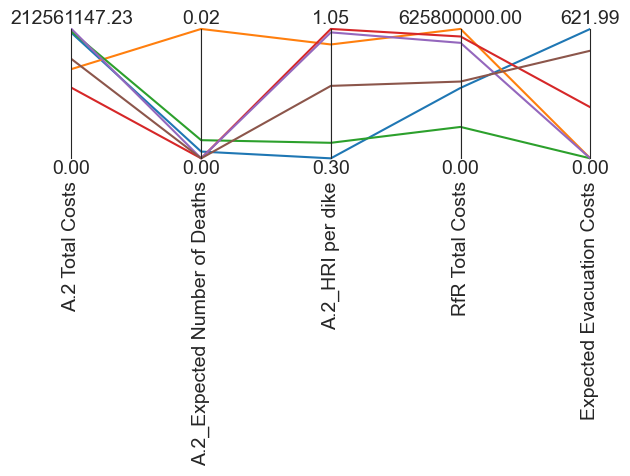

In [142]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0

 # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Save the plot
plt.savefig("mordm_parallel coordinates all.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Visualization of the policies with the hard tresholds

In [143]:
# === Apply Hard Thresholds to Filter Policies ===

# Define filtering logic:
# - Total costs must be below 200 million (2e8)
# - Hydrological Resilience Index (HRI) per dike must be above 0.7
logical = (
    (results["A.2 Total Costs"] < 2e8) &
    (results["A.2_HRI per dike"] > 0.7)
)

# Count how many policies meet both conditions
np.sum(logical)

np.int64(3)

/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_6609/2182691988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_1["policy"] = results_1.index  # e.g., 16, 17, 18...


<Figure size 1400x1000 with 0 Axes>

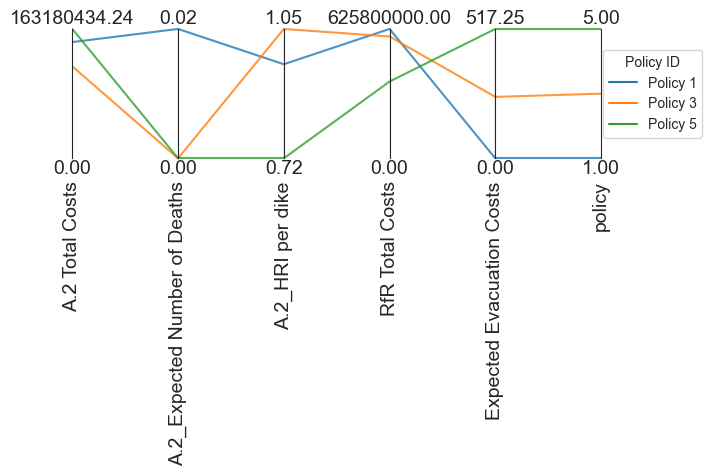

In [144]:
# === FILTER AND PREPARE DATA FOR PARALLEL COORDINATE PLOT ===

# Filter the MORDM results using a logical condition (e.g., cost < threshold and HRI > threshold)
results_1 = results[logical]

# Add a 'policy' column using the DataFrame index for identification
results_1["policy"] = results_1.index  # e.g., 16, 17, 18...

# Extract only the outcome variables and the new 'policy' column for plotting
data = results_1.loc[:, [o.name for o in model.outcomes] + ['policy']]

# --- Set up plot axis limits for better readability ---
limits = parcoords.get_limits(data)

# Manually set the lower bounds for specific outcomes to 0 to ensure aligned visual comparison
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0

# --- Assign a unique color to each policy ---
policy_ids = data["policy"].unique()  # List of policy identifiers
colors = sns.color_palette("tab10", len(policy_ids))  # Generate distinct colors
color_map = dict(zip(policy_ids, colors))  # Create dictionary mapping policy ID → color

# --- Create the parallel coordinates plot ---
plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)  # Create plotting canvas with axis ranges from 'limits'

# Plot each policy (row of data) in its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")  # Fallback to gray if ID missing
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# --- Create legend for policy identification ---
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]

# Place legend outside the plot on the right
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",
           bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

# --- Save and display the final figure ---
plt.savefig("parallel_coords_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

## optimized policies

In [145]:
# === Extract Acceptable Policies Based on Hard Thresholds ===

# 1. Filter only the policies that met the hard criteria
# (these were defined earlier as: Total Costs < 200 million AND HRI per dike > 0.7)
policies = results[logical]

# 2. Remove the outcome columns to leave only the policy levers
# This isolates the actual policy decisions (i.e. lever values) from performance outcomes
policies = policies.drop([o.name for o in model.outcomes], axis=1)

# 3. Display the selected robust policy configurations
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,0,0,0,0,1,0,0,0,1,0,...,9,0,7,2,2,7,1,7,3,0
3,1,0,0,1,0,0,0,1,0,0,...,0,2,5,10,6,5,7,10,7,3
5,1,0,0,0,0,0,0,1,0,0,...,3,1,3,8,4,4,7,4,3,5


In [146]:
# === Convert Selected Policies to EMA Policy Objects ===

# Initialize list to store Policy objects
policies_to_evaluate = []

# Loop through each row (policy) in the filtered DataFrame
for i, policy in policies.iterrows():
    # Convert the row into a dictionary of lever values
    policy_dict = policy.to_dict()

    # Create a Policy object with a unique name (based on index) and lever values
    policies_to_evaluate.append(Policy(str(i), **policy_dict))

## Save the polcies that are going to be used for the rest of the analysis

In [147]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
#policies_df = results[lever_names]
policies.to_csv("candidate_policies.csv", index=False)

In [148]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments

100%|████████████████████████████████████████| 300/300 [00:57<00:00,  5.25it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Robustness analysis using the regret matrix

In [149]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [150]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
1,2.037457e+16,6.016861e-03,8.646911e+15,625800000.0,0.000000e+00
3,1.057950e+15,4.186285e-07,1.050000e+00,589200000.0,1.680055e+07
5,1.998536e+15,6.308726e-07,6.485183e+15,371400000.0,4.385452e+07


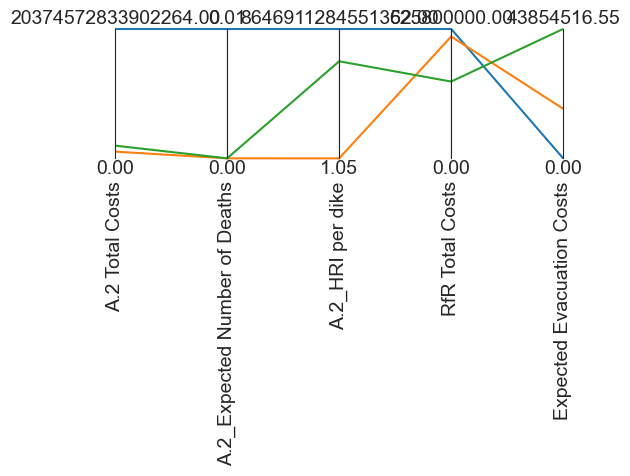

<Figure size 1400x1000 with 0 Axes>

In [151]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

plt.figure(figsize=(14, 10))
plt.savefig("scores_single_MORDM.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches
plt.show()

In [152]:
def calculate_regret(data, best):
    """
    Calculate absolute regret for each value in `data` relative to `best`.

    Parameters:
    - data (array-like): Array of outcome values for different policies or scenarios.
    - best (float or array-like): Best (optimal) outcome(s) to compare against.

    Returns:
    - regret (ndarray): Absolute regret values (how much worse each value is compared to the best).
    """
    return np.abs(best - data)

In [153]:
# Unpack experiment results
experiments, outcomes = results

# Initialize dictionaries to store regrets
overall_regret = {}  # Regret for each outcome across all scenarios
max_regret = {}      # Max regret per policy for each outcome

# Loop through all outcomes defined in the model
for outcome in model.outcomes:
    # Extract relevant information: outcome values, policies, scenario IDs
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name],
        "policy": experiments['policy'],
        "scenario": experiments['scenario']
    })

    # Reshape: rows = scenarios, columns = policies
    data = data.pivot(index='scenario', columns='policy')

    # Flatten multi-index columns created by pivoting
    data.columns = data.columns.get_level_values(1)

    # Compute absolute regret:
    # For each scenario (row), subtract all policy scores from the best policy score
    # (i.e., the max value in that row), then take absolute value of differences
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    # Store full regret matrix and max regret (per policy) for this outcome
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

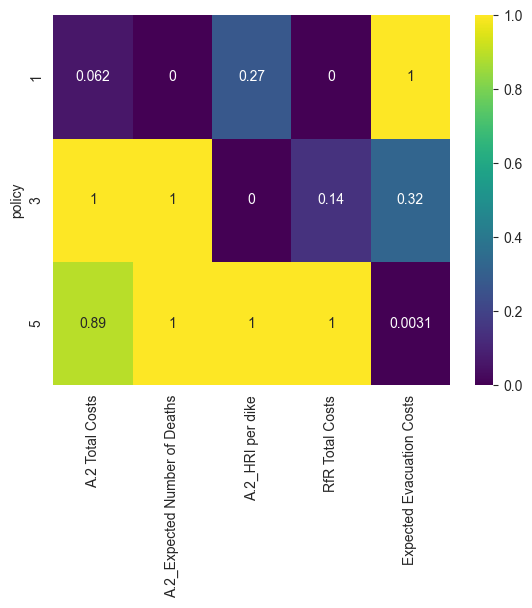

In [154]:
# Convert max_regret dictionary to DataFrame:
# Rows = policies, Columns = outcomes
max_regret = pd.DataFrame(max_regret)

# Normalize regret scores by dividing by the maximum regret per outcome
# This rescales each column to [0, 1], making comparisons easier across outcomes
normalized_regret = max_regret / max_regret.max()

# Plot heatmap using Seaborn
sns.heatmap(normalized_regret, cmap='viridis', annot=True)

# Save the figure as a high-resolution PNG
plt.savefig("regret_single_MORDM.png", dpi=300, bbox_inches='tight')
plt.show()

## PRIM analysis with the polcies out of the MORDM found and saved earlier

In this section, PRIM (Patient Rule Induction Method) is used to identify three key worst-case scenarios based on low hydrological resilience and high total costs. These scenarios highlight critical combinations of uncertainties that challenge policy performance. The results guide the selection of representative scenarios for the multi-scenario MORDM analysis. Supporting visualizations,such as dimensional stacking—help illustrate the logic behind the scenario selection.

In [155]:
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [156]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=100
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments

100%|████████████████████████████████████████| 300/300 [00:33<00:00,  8.88it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### ===  DEFINE WORST-CASE CONDITIONS FOR PRIM ===

In [157]:
# Extract system-wide Hydrological Resilience Index values for each experiment
hri_sys = outcomes["A.2_HRI per dike"]

# Define worst-case: scenarios with HRI in the lowest 25%
hri_q25 = np.percentile(hri_sys, 25)
target_hri = hri_sys <= hri_q25  # Boolean array (True if HRI is low)

# Extract total cost values (e.g., damages + investments)
ead_total = outcomes["A.2 Total Costs"]

# Define worst-case: scenarios with total cost in the highest 25%
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75  # Boolean array (True if cost is high)

# Combine both worst-case definitions using logical OR
# A run is a 'worst-case' if it has low HRI OR high total cost
y = target_hri | target_ead

print(f"Worst-cases: {y.sum()} of {len(y)} runs  ({y.mean()*100:.1f}%)")

# === 2. SET UP EXPLANATORY INPUT MATRIX (X) WITH UNCERTAINTIES ===

# Get column names of uncertainties from the model
cols_unc = [u.name for u in model.uncertainties]

# Create DataFrame X with only the uncertainty columns
X = experiments[cols_unc]

# === 3. RUN PRIM TO FIND REGIONS IN UNCERTAINTY SPACE LINKED TO WORST CASES ===

# Initialize PRIM algorithm with:
# X = input features (uncertainties), y = target (worst-case labels), threshold = coverage target
prim_alg = prim.Prim(X, y, threshold=0.80)

# At this point, you can call prim_alg.find_box() to identify clusters of bad outcomes
print("Amount of saved boxes:", len(prim_alg.boxes))

Worst-cases: 136 of 300 runs  (45.3%)
Amount of saved boxes: 1


[MainProcess/INFO] 300 points remaining, containing 136 cases of interest
[MainProcess/INFO] box mean (0.7619047619047619) does not meet threshold criteria (1 0.8),returning dump box


coverage      1.000000
density       0.453333
id            0.000000
k           136.000000
mass          1.000000
mean          0.453333
n           300.000000
res_dim       0.000000
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []



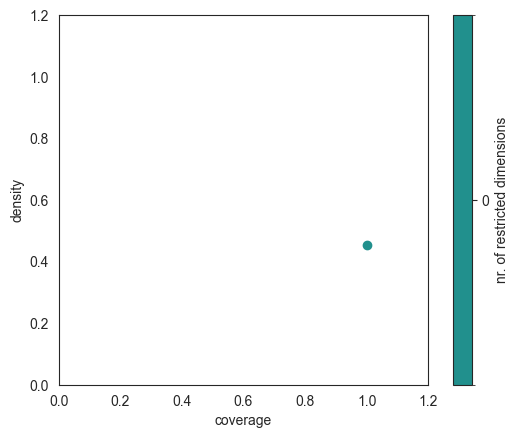

1 steps in the box


In [158]:
# === A) SELECT AND INSPECT THE BEST PRIM BOX ===

# Find the "best" PRIM box according to the defined coverage threshold (e.g., 80%)
# This will identify a subregion of the uncertainty space where 'worst-case' outcomes are concentrated
box = prim_alg.find_box()

# Inspect the final selected box
# This shows constraints (upper/lower bounds) on the uncertainties for the selected box
box.inspect()

# Visualize the trade-off between coverage (how many of the target outcomes are inside the box)
# and density (how many of the box's members are truly bad outcomes)
box.show_tradeoff()
plt.show()

# Extract the peeling trajectory: a log of all steps the PRIM algorithm took to reduce the box size
# Each step tries to improve the balance between coverage and density
traj = box.peeling_trajectory

# Print how many refinement steps were made to arrive at the final box
print(len(traj), "steps in the box")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/scenario_discovery_util.py:555: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(top=-0.5, bottom=nr_unc - 0.5)


[<Figure size 640x480 with 1 Axes>]

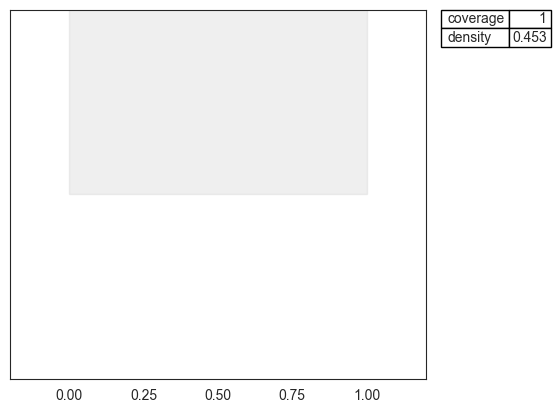

In [159]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

In [161]:
# fig = box.show_pairs_scatter()
# plt.show()

ValueError: No variables found for grid columns.

[MainProcess/INFO] model dropped from analysis because only a single category


original amount of columns: 53
without levers           : 22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


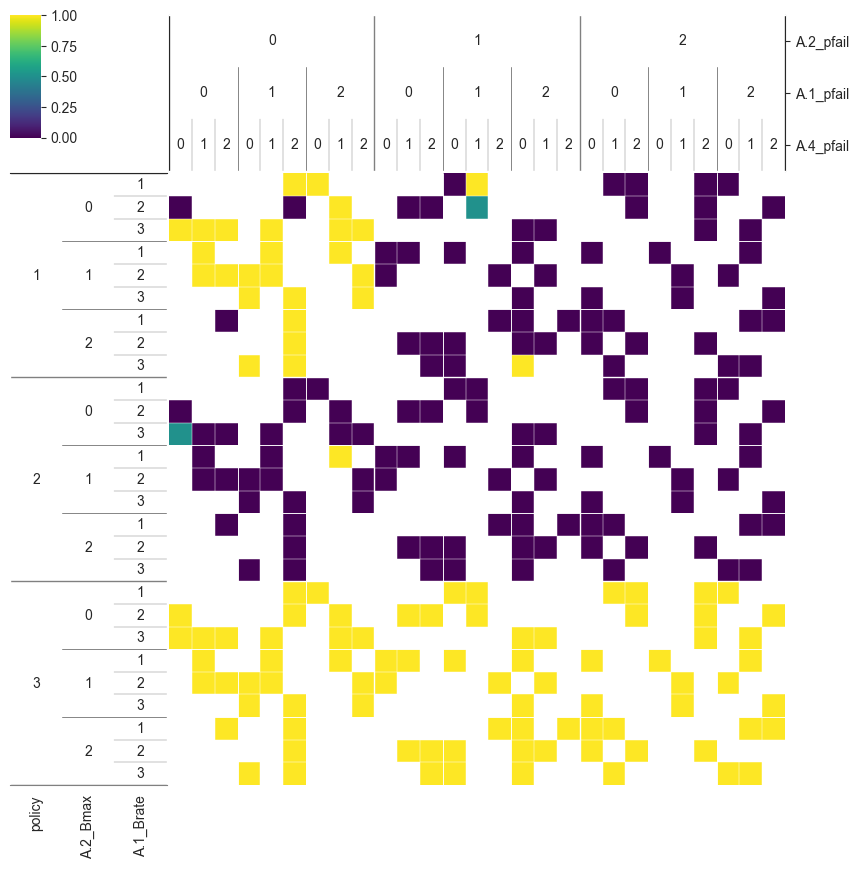

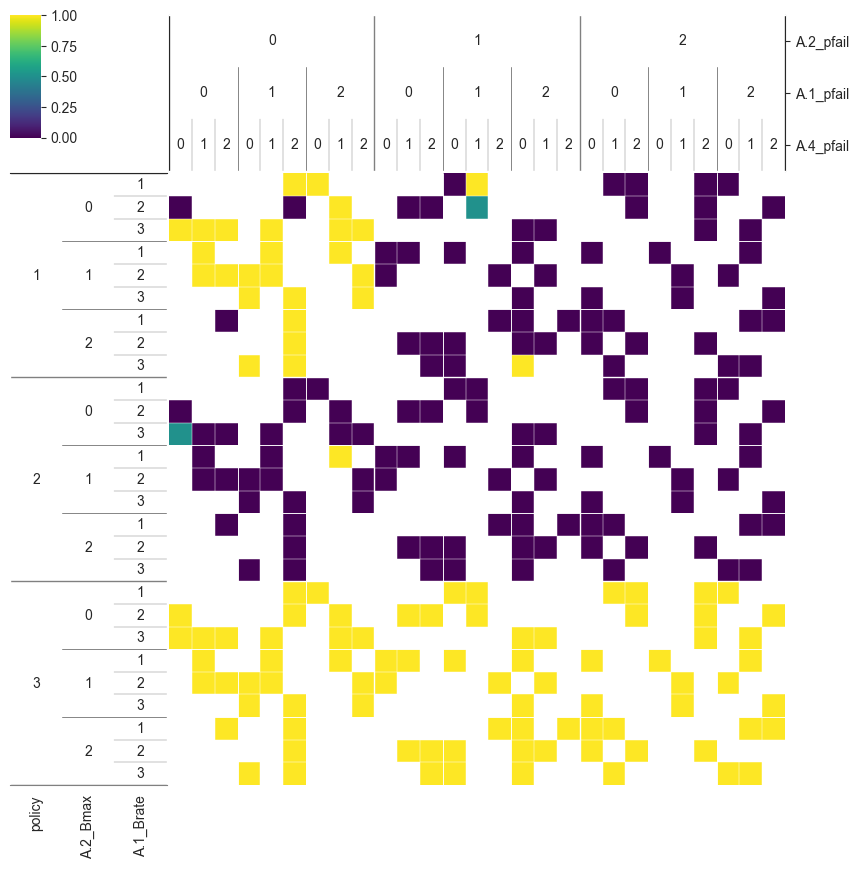

In [162]:
# === DIMENSIONAL STACKING TO EXPLORE UNCERTAINTY SPACE ===

# 1. Extract the names of all levers from the model
# This helps us separate controllable policy inputs from uncontrollable uncertainties
lever_names = [lev.name for lev in model.levers]

# 2. Remove levers from the experimental design so only uncertainties remain
# This is necessary for dimensional stacking, which is focused on the influence of uncertainties
experiments_unc = experiments.drop(columns=lever_names)

# 3. Check how many columns remain (i.e., uncertainty parameters only)
# Useful sanity check to ensure the drop operation worked correctly
print("original amount of columns:", experiments.shape[1])
print("without levers           :", experiments_unc.shape[1])

# 4. Create a dimensional stacking pivot plot
# This plots the most influential uncertainties on a 2D grid to visualize where "bad" outcomes occur
# `y` is a boolean array where 1 = worst-case outcome, defined earlier
dimensional_stacking.create_pivot_plot(experiments_unc, y)

In [163]:
# === EXTRACT UNCERTAINTY LIMITS FROM SELECTED PRIM BOX ===

# 1) Retrieve the raw limits of the first box from the peeling trajectory
# This provides the min/max boundaries for each uncertainty in the box
raw_limits = box.box_lims[0]  # shape: (variables, 2)

# 2) Transpose the limits so each uncertainty becomes a row
# Now each row corresponds to one variable, with columns [min, max]
df_lim = raw_limits.T

# 3) Rename the default column names for clarity
# Column 0 becomes "min", column 1 becomes "max"
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 4) Optionally set the name of the index to "var" for better readability
# This index lists all uncertainty variable names
df_lim.index.name = "var"


In [164]:
# Step 1: Use the threshold boundaries (min/max per variable) defined by the selected PRIM box
df_lim  # This DataFrame holds the limits per uncertainty from the PRIM box

# Step 2: Create a boolean mask to filter experiments that fall within the box
mask = pd.Series(True, index=experiments.index)


# Step 3: Loop over each variable and apply the respective boundaries
for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # If the variable is numeric, apply range-based filtering
        mask &= ser.between(lo, hi)
    else:
        # If the variable is categorical
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)  # Keep if value in allowed list/set
        else:
            mask &= (ser == lo)   # Keep if value matches the only allowed value


# Step 4: Apply the final mask to get the filtered experiments
exp_in_box = experiments[mask]  # Experiments within the PRIM box

# Step 5: Apply the same mask to each outcome array
# This keeps only the outcome results that correspond to the selected experiments
out_in_box = {
    name: array[mask.values]  # Convert the pandas Series mask to a NumPy array
    for name, array in outcomes.items()
}


In [165]:
# === Expand multi-dimensional outcomes (e.g., time series) to a flat DataFrame ===

expanded = {}

for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # If the outcome is a 1D array (single value per experiment), keep it as is
        expanded[name] = arr
    else:
        # If the outcome is a 2D array (e.g., time series), expand each timestep into its own column
        T = arr.shape[1]  # Number of time steps
        for t in range(T):
            # Create a new column name like "OutcomeName_0", "OutcomeName_1", etc.
            expanded[f"{name}_{t}"] = arr[:, t]

# Combine all processed outcomes into a single DataFrame for easy export or analysis
out_df = pd.DataFrame(expanded)


In [166]:
exp_in_box['worst_case']=y[exp_in_box.index]
true_worst= exp_in_box[exp_in_box['worst_case']]

In [167]:
# === Match total costs to identified worst-case experiments ===

# 1) Create a pandas Series of total costs for all experiments inside the PRIM box,
# using the original experiment indices for alignment.
all_costs = pd.Series(
    out_in_box['A.2 Total Costs'],  # Outcome array from PRIM box subset
    index=exp_in_box.index          # Ensure correct alignment using original indices
)

# 2) Filter the Series to include only the experiments that are in the 'true_worst' subset
# These are typically worst-performing runs based on earlier selection (e.g., high EAD or low HRI)
worst_costs = all_costs.loc[true_worst.index]

# 3) Add the filtered total costs as a new column to the 'true_worst' DataFrame
true_worst = true_worst.assign(total_costs=worst_costs)

In [168]:
# Assign total costs from the PRIM-in-box experiments to the true_worst DataFrame,
# ensuring index alignment via .loc[]
true_worst['total_costs'] = (
    pd.Series(out_in_box['A.2 Total Costs'], index=exp_in_box.index)
    .loc[true_worst.index]
)

In [169]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs
1,97,267.311961,10.0,0.825178,92.922873,1.5,0.050406,300.634873,1.0,0.466264,...,7,1,7,3,0,1221,cand_0,dikesnet,True,5.942331e+08
3,117,257.631263,1.0,0.606278,48.849833,1.0,0.173812,306.028736,1.0,0.230508,...,7,1,7,3,0,1223,cand_0,dikesnet,True,2.883581e+08
7,75,315.606177,1.0,0.518673,330.388113,1.0,0.141912,39.672460,1.5,0.527780,...,7,1,7,3,0,1227,cand_0,dikesnet,True,2.853413e+08
11,5,346.360238,1.5,0.341074,300.935136,10.0,0.251641,250.048850,1.5,0.019636,...,7,1,7,3,0,1231,cand_0,dikesnet,True,1.991951e+08
13,23,53.726671,1.0,0.397506,170.215303,1.0,0.247617,246.148986,10.0,0.672843,...,7,1,7,3,0,1233,cand_0,dikesnet,True,1.833044e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,19,108.416287,1.5,0.811001,108.476214,10.0,0.799684,275.203157,1.0,0.022374,...,4,7,4,3,5,1315,cand_2,dikesnet,True,1.631804e+08
296,11,265.132593,1.0,0.905043,271.326210,10.0,0.564715,140.694879,10.0,0.500822,...,4,7,4,3,5,1316,cand_2,dikesnet,True,1.631804e+08
297,83,240.693912,10.0,0.919497,130.157419,10.0,0.779496,61.150430,10.0,0.657391,...,4,7,4,3,5,1317,cand_2,dikesnet,True,1.631804e+08
298,110,174.428597,10.0,0.977741,262.219606,1.5,0.401720,82.008361,1.5,0.309475,...,4,7,4,3,5,1318,cand_2,dikesnet,True,1.631804e+08


In [170]:
# --- 1) Create a Series of all HRI values (per dike), using the original index ---
all_HRI = pd.Series(
    out_in_box['A.2_HRI per dike'],  # HRI values for all runs in the PRIM box
    index=exp_in_box.index           # Ensure the same index is used
)

# --- 2) Filter HRI values to match the worst-case subset based on true_worst's index ---
worst_HRI = all_HRI.loc[true_worst.index]

# --- 3) Assign filtered HRI values as a new column in true_worst ---
true_worst = true_worst.assign(HRI=worst_HRI)

In [171]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs,HRI
1,97,267.311961,10.0,0.825178,92.922873,1.5,0.050406,300.634873,1.0,0.466264,...,1,7,3,0,1221,cand_0,dikesnet,True,5.942331e+08,0.96
3,117,257.631263,1.0,0.606278,48.849833,1.0,0.173812,306.028736,1.0,0.230508,...,1,7,3,0,1223,cand_0,dikesnet,True,2.883581e+08,0.96
7,75,315.606177,1.0,0.518673,330.388113,1.0,0.141912,39.672460,1.5,0.527780,...,1,7,3,0,1227,cand_0,dikesnet,True,2.853413e+08,0.96
11,5,346.360238,1.5,0.341074,300.935136,10.0,0.251641,250.048850,1.5,0.019636,...,1,7,3,0,1231,cand_0,dikesnet,True,1.991951e+08,0.96
13,23,53.726671,1.0,0.397506,170.215303,1.0,0.247617,246.148986,10.0,0.672843,...,1,7,3,0,1233,cand_0,dikesnet,True,1.833044e+08,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,19,108.416287,1.5,0.811001,108.476214,10.0,0.799684,275.203157,1.0,0.022374,...,7,4,3,5,1315,cand_2,dikesnet,True,1.631804e+08,0.72
296,11,265.132593,1.0,0.905043,271.326210,10.0,0.564715,140.694879,10.0,0.500822,...,7,4,3,5,1316,cand_2,dikesnet,True,1.631804e+08,0.72
297,83,240.693912,10.0,0.919497,130.157419,10.0,0.779496,61.150430,10.0,0.657391,...,7,4,3,5,1317,cand_2,dikesnet,True,1.631804e+08,0.72
298,110,174.428597,10.0,0.977741,262.219606,1.5,0.401720,82.008361,1.5,0.309475,...,7,4,3,5,1318,cand_2,dikesnet,True,1.631804e+08,0.72


In [172]:
# 1) Normalize HRI and total costs using min-max scaling
hri = true_worst['HRI']
cost = true_worst['total_costs']

# Rescale both to [0, 1]
hri_scaled = (hri - hri.min()) / (hri.max() - hri.min())
cost_scaled = (cost - cost.min()) / (cost.max() - cost.min())

# 2) Invert costs so that lower costs correspond to higher 'desirability'
inv_cost = 1 - cost_scaled

# 3) Compute composite score as the product of scaled HRI and inverted cost
score = hri_scaled * inv_cost

# 4) Add all scaled components and composite score back to DataFrame
true_worst = true_worst.assign(
    hri_scaled = hri_scaled,
    cost_scaled = cost_scaled,
    inv_cost = inv_cost,
    score = score
)

# Preview the resulting DataFrame with new score columns
true_worst.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
1,97,267.311961,10.0,0.825178,92.922873,1.5,0.050406,300.634873,1.0,0.466264,...,1221,cand_0,dikesnet,True,5.942331e+08,0.96,0.932331,0.636801,0.363199,0.338622
3,117,257.631263,1.0,0.606278,48.849833,1.0,0.173812,306.028736,1.0,0.230508,...,1223,cand_0,dikesnet,True,2.883581e+08,0.96,0.932331,0.184927,0.815073,0.759918
7,75,315.606177,1.0,0.518673,330.388113,1.0,0.141912,39.672460,1.5,0.527780,...,1227,cand_0,dikesnet,True,2.853413e+08,0.96,0.932331,0.180470,0.819530,0.764073
11,5,346.360238,1.5,0.341074,300.935136,10.0,0.251641,250.048850,1.5,0.019636,...,1231,cand_0,dikesnet,True,1.991951e+08,0.96,0.932331,0.053205,0.946795,0.882726
13,23,53.726671,1.0,0.397506,170.215303,1.0,0.247617,246.148986,10.0,0.672843,...,1233,cand_0,dikesnet,True,1.833044e+08,0.96,0.932331,0.029729,0.970271,0.904613


In [173]:
# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nlargest(1, 'score')   #best case is hoogste
worst = true_worst.nsmallest(1,  'score')      #worst case is laagste
mid   = true_worst.iloc[[len(true_worst)//2]]

In [174]:
# Step 1: Convert single-row DataFrames to Series
best_s   = best.iloc[0]      # Extract best-case row as Series
mid_s    = mid.iloc[0]       # Extract median-case row as Series
worst_s  = worst.iloc[0]     # Extract worst-case row as Series

# Step 2: Combine all three Series into a DataFrame
df_scenarios = pd.DataFrame([
    best_s.to_dict(),        # Convert each Series to dictionary
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])  # Set custom labels

In [175]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
best_case,131,185.101442,1.0,0.895361,165.869839,1.0,0.014641,137.960881,10.0,0.129001,...,1266,cand_1,dikesnet,True,1.788587e+08,1.05,1.000000,0.023162,0.976838,0.976838
median_case,24,150.378573,1.5,0.883631,303.920506,1.5,0.471273,185.730489,1.5,0.875238,...,1252,cand_2,dikesnet,True,1.631804e+08,0.72,0.751880,0.000000,1.000000,0.751880
worst_case,77,79.951411,10.0,0.610489,98.309920,1.5,0.031183,31.018025,10.0,0.647644,...,1274,cand_0,dikesnet,True,8.400840e+08,0.96,0.932331,1.000000,0.000000,0.000000


### The three scenarios that come out of the PRIM are saved for further use in the next section

In [176]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")


In [177]:
candidate_scenarios = [
    Scenario(f"scenario_{idx}", **row.to_dict())
    for idx, row in df_scenarios.iterrows()
]

In [178]:
for scenario in candidate_scenarios:
    print(scenario)

Scenario({'A.0_ID flood wave shape': 131, 'A.1_Bmax': 185.10144212413113, 'A.1_Brate': 1.0, 'A.1_pfail': 0.8953610458326217, 'A.2_Bmax': 165.86983941210832, 'A.2_Brate': 1.0, 'A.2_pfail': 0.01464090157747314, 'A.3_Bmax': 137.96088100891262, 'A.3_Brate': 10.0, 'A.3_pfail': 0.1290011566700227, 'A.4_Bmax': 303.6222924521218, 'A.4_Brate': 10.0, 'A.4_pfail': 0.5384635830245277, 'A.5_Bmax': 207.7274400895723, 'A.5_Brate': 1.0, 'A.5_pfail': 0.273686466083706, 'discount rate 0': 2.5, 'discount rate 1': 3.5, 'discount rate 2': 2.5, '0_RfR 0': 1, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 1, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 1, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 4, 'A.1_DikeIncrease 0': 6, 'A.1_DikeIncrease 1': 1, 'A.1_DikeIncrease 2': 6, 'A.2_DikeIncrease 0': 5, 'A.2_DikeIncrease 1': 3, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 2, 'A.3_DikeIncrease 1': 5, 'A.3_DikeIncrease 2': 10, 'A.4_DikeInc

## Multi-scenario MORDM with the three scenarios out of the PRIM analysis

In [179]:

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [180]:
# === Multi-Scenario MORDM Optimization ===
# This script performs multi-objective optimization under multiple future scenarios
# using EMA Workbench and ε-NSGAII, constrained to limit RfR projects.
# Enable logging for debugging and progress tracking
ema_logging.log_to_stderr(ema_logging.INFO)

# === Optimization Parameters ===
nfe = 150  # Number of function evaluations per scenario
epsilons = [0.01] * len(model.outcomes)  # ε values for each objective (precision of Pareto front)

# Initialize lists to collect optimization results and convergence records
results = []
convergence_records = []

# Start parallel evaluation
with MultiprocessingEvaluator(model) as evaluator:

    # Loop over the first 3 discovered candidate scenarios (e.g., from PRIM)
    for i, scenario in enumerate(candidate_scenarios[:3]):
        print(f"🔄 Running: Scenario {i} ({scenario.name})")

        # Define convergence tracking object
        eps_prog = EpsilonProgress()

        # Run the optimization for this scenario
        result, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",          # Only search over decision levers
            epsilons=epsilons,            # Epsilon values for Pareto sorting
            convergence=[eps_prog],       # Track convergence
            reference=scenario,           # Use current scenario as fixed uncertainty setting
            constraints=[max_one_rfr_constraint]  # Apply RfR policy constraint
        )

        # Store the resulting Pareto-optimal solutions for this scenario
        results.append(pd.DataFrame(result))

        # Store the convergence data (already a DataFrame)
        convergence_df = pd.DataFrame(convergence)
        convergence_df["scenario"] = scenario.name  # Tag with scenario name
        convergence_records.append(convergence_df)

# === Merge results from all scenarios into unified DataFrames ===

# Combine all Pareto-optimal policy results
combined_results = pd.concat(results, ignore_index=True)

# Combine all convergence logs for plotting or diagnostics
convergence_df = pd.concat(convergence_records, ignore_index=True)

[MainProcess/INFO] pool started with 8 workers


🔄 Running: Scenario 0 (scenario_best_case)



  0%|                                                  | 0/150 [00:00<?, ?it/s]INFO | EpsNSGAII starting

 67%|██████████████████████████▋             | 100/150 [00:11<00:05,  8.71it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:23.179502

200it [00:23,  8.63it/s]                                                       
[MainProcess/INFO] optimization completed, found 8 solutions


🔄 Running: Scenario 1 (scenario_median_case)



  0%|                                                  | 0/150 [00:00<?, ?it/s]INFO | EpsNSGAII starting

 67%|██████████████████████████▋             | 100/150 [00:11<00:05,  8.38it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:25.214968

200it [00:25,  7.93it/s]                                                       
[MainProcess/INFO] optimization completed, found 6 solutions


🔄 Running: Scenario 2 (scenario_worst_case)



  0%|                                                  | 0/150 [00:00<?, ?it/s]INFO | EpsNSGAII starting

 67%|██████████████████████████▋             | 100/150 [00:15<00:07,  6.27it/s]INFO | EpsNSGAII finished; Total NFE: 200, Elapsed Time: 0:00:32.212253

200it [00:32,  6.21it/s]                                                       
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


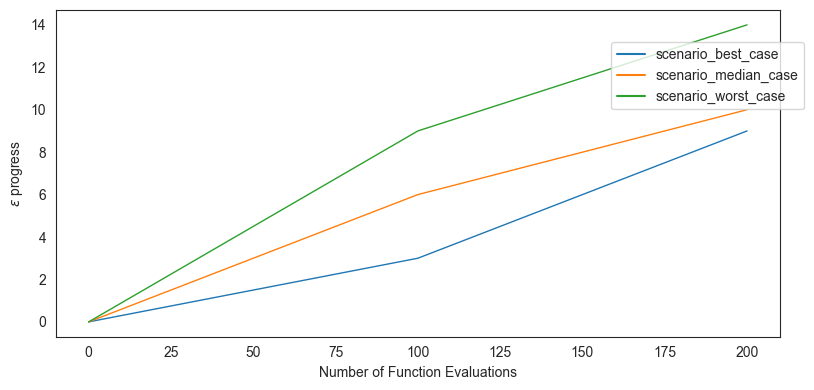

In [181]:
# === PLOT ε-PROGRESS BY SCENARIO ===
# This plot visualizes the convergence behavior of the ε-NSGAII algorithm for each scenario.
# The ε-progress metric shows how much the Pareto front improves as the optimization proceeds.

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Use Seaborn's default color palette to differentiate scenarios
colors = sns.color_palette()

# Prepare a list to store legend entries
legend_items = []

# Loop through convergence data grouped by scenario
for (scenario_name, scores), color in zip(convergence_df.groupby("scenario"), colors):

    # Add a legend entry for this scenario with the matching color
    legend_items.append((mpl.lines.Line2D([0], [1], color=color), scenario_name))

    # Plot ε-progress for this scenario over the number of function evaluations (nfe)
    ax.plot(scores.nfe, scores.epsilon_progress, color=color, lw=1)

# Set axis labels with LaTeX-style formatting for epsilon
ax.set_ylabel(r'$\epsilon$ progress')
ax.set_xlabel('Number of Function Evaluations')

# Unpack and apply legend items (lines + labels)
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1.02, 0.9))  # Place legend outside the plot

# Tight layout to prevent overlap and cutoffs
plt.tight_layout()

# Save the figure to disk
plt.savefig("convergence_multi_mordm.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [182]:
combined_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,0,0,1,0,0,0,0,...,10,9,6,6,0,1.526590e+08,0.000550,0.65,595100000.0,1520.538188
1,0,0,0,0,0,0,1,0,0,0,...,2,4,10,8,9,3.809317e+08,0.000537,0.61,408000000.0,17431.721880
2,0,1,0,0,0,1,1,0,0,0,...,10,9,5,7,2,1.496136e+08,0.000195,1.05,710400000.0,749.058953
3,0,0,1,0,0,0,1,0,0,0,...,5,4,10,10,5,5.704100e+08,0.039621,0.61,236500000.0,25886.563333
4,0,0,0,0,0,1,0,0,0,0,...,3,5,6,8,1,3.065618e+08,0.000947,0.21,339000000.0,2061.840523
5,0,0,1,1,0,0,0,1,0,0,...,9,4,6,5,0,5.231651e+08,0.045204,0.99,589200000.0,16204.897567
6,0,0,0,0,0,1,0,0,0,0,...,5,6,7,4,5,3.393677e+08,0.001579,0.95,595100000.0,857.718372
7,0,0,0,0,0,1,1,0,0,0,...,10,6,1,0,0,2.661364e+08,0.000195,0.98,625800000.0,8029.775404
8,0,1,0,0,0,0,1,0,0,0,...,1,3,10,8,9,1.974027e+08,0.001166,0.66,371400000.0,632.620283
9,0,1,0,0,0,1,0,0,1,0,...,6,0,8,1,8,1.842113e+08,0.000194,0.57,710400000.0,173.745407


In [183]:
print(combined_results)

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        0        0        0        1        0        0   
1         0        0        0        0        0        0        1        0   
2         0        1        0        0        0        1        1        0   
3         0        0        1        0        0        0        1        0   
4         0        0        0        0        0        1        0        0   
5         0        0        1        1        0        0        0        1   
6         0        0        0        0        0        1        0        0   
7         0        0        0        0        0        1        1        0   
8         0        1        0        0        0        0        1        0   
9         0        1        0        0        0        1        0        0   
10        0        0        0        0        0        1        0        0   
11        0        0        1        0        0        0        

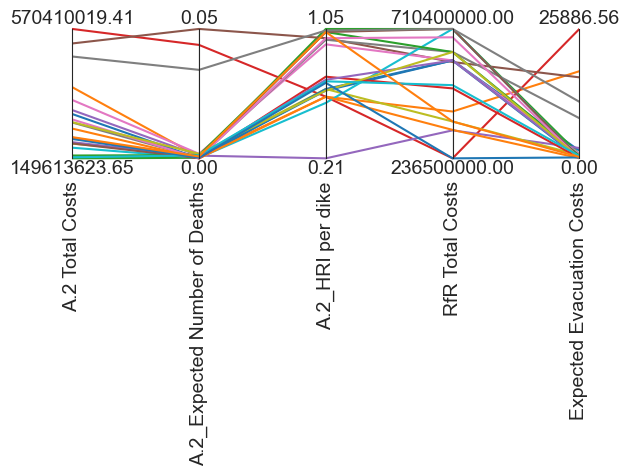

<Figure size 1400x1000 with 0 Axes>

In [184]:
data = combined_results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))
plt.savefig("multi mordm all.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches


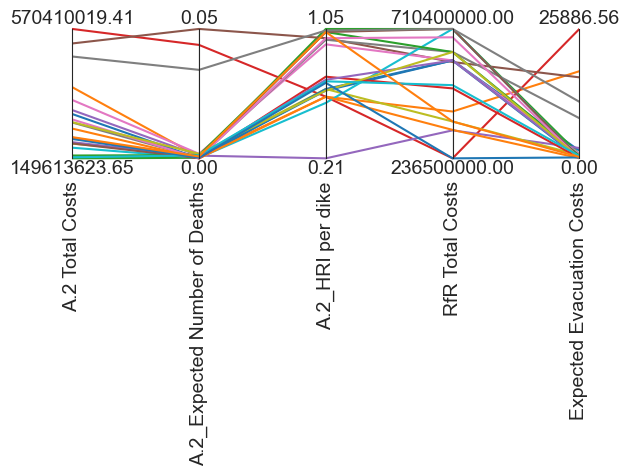

In [185]:

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)


# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [186]:
# === Define Policy Filtering Logic ===
# This logical condition selects only the policies that meet both of the following:
# 1. Total costs for location A.2 are under 400 million euros
# 2. Hydrological Resilience Index (HRI) per dike for A.2 is greater than 0.7
# These thresholds reflect hard constraints used by the Waterboard Veluwe to filter feasible and desirable policies.

logical = (
    (combined_results["A.2 Total Costs"] < 4e8) &  # 400 million = 4e8
    (combined_results["A.2_HRI per dike"] > 0.7)
)

# === Count the Number of Policies that Meet the Criteria ===
# This tells us how many candidate policies survive the hard filters
np.sum(logical)

# === Return Filtered Policies ===
# This gives the actual dataframe of all policies that meet both criteria
# It's useful for further inspection, plotting, or running detailed simulations
combined_results[logical]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
2,0,1,0,0,0,1,1,0,0,0,...,10,9,5,7,2,1.496136e+08,0.000195,1.05,710400000.0,749.058953
6,0,0,0,0,0,1,0,0,0,0,...,5,6,7,4,5,3.393677e+08,0.001579,0.95,595100000.0,857.718372
7,0,0,0,0,0,1,1,0,0,0,...,10,6,1,0,0,2.661364e+08,0.000195,0.98,625800000.0,8029.775404
12,0,0,0,0,1,0,1,0,0,0,...,9,4,4,5,6,1.587758e+08,0.001155,1.03,625800000.0,540.277499
13,0,1,0,0,0,0,1,0,0,0,...,6,0,4,1,7,2.166808e+08,0.000000,0.74,492600000.0,79.324184
14,0,0,0,1,0,0,0,0,0,0,...,4,0,2,10,3,2.021128e+08,0.000671,0.72,595100000.0,196.436915
15,0,1,0,0,1,0,1,0,0,0,...,1,6,1,2,1,1.980745e+08,0.000095,1.03,710400000.0,105.482896
16,1,0,0,1,0,0,0,0,0,0,...,1,10,10,8,5,2.760940e+08,0.000000,0.99,679700000.0,0.000000
19,0,0,0,0,1,0,1,0,0,0,...,6,1,4,6,5,1.528509e+08,0.001059,0.71,504600000.0,485.466625
21,0,1,0,0,0,0,1,0,0,0,...,3,10,0,9,1,2.185753e+08,0.000662,1.03,371400000.0,270.078681


/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_6609/3173083973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2["policy"] = results_2.index


<Figure size 1400x1000 with 0 Axes>

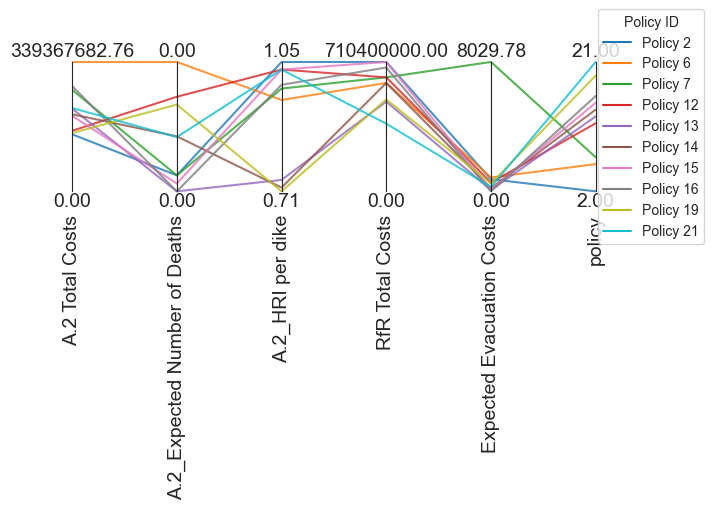

In [187]:
# Step 1: Filter results using logical constraints (already defined earlier)
results_2 = combined_results[logical]

# Step 2: Add a 'policy' column using the DataFrame index
results_2["policy"] = results_2.index

# Step 3: Select only outcome columns and policy identifiers
data = results_2.loc[:, [o.name for o in model.outcomes] + ['policy']]

# Step 4: Define limits for the parallel axes (for consistent scaling)
limits = parcoords.get_limits(data)

# Step 5: Manually set minimums to zero for key outcomes (for clearer interpretation)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0

# Step 6: Assign colors to each unique policy for visual distinction
policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))

# Step 7: Create the parallel coordinates plot
plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each row (i.e., each policy) with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Step 8: Add legend mapping policy IDs to line colors
legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",
           bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

# Step 9: Save the figure and show it
plt.savefig("parallel_coords_multi_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

In [188]:
policies = combined_results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
2,0,1,0,0,0,1,1,0,0,0,...,0,4,8,1,7,10,9,5,7,2
6,0,0,0,0,0,1,0,0,0,0,...,10,10,9,1,9,5,6,7,4,5
7,0,0,0,0,0,1,1,0,0,0,...,7,4,9,2,5,10,6,1,0,0
12,0,0,0,0,1,0,1,0,0,0,...,2,4,4,10,2,9,4,4,5,6
13,0,1,0,0,0,0,1,0,0,0,...,1,1,2,5,9,6,0,4,1,7
14,0,0,0,1,0,0,0,0,0,0,...,3,6,9,2,8,4,0,2,10,3
15,0,1,0,0,1,0,1,0,0,0,...,2,2,7,3,2,1,6,1,2,1
16,1,0,0,1,0,0,0,0,0,0,...,6,7,2,1,10,1,10,10,8,5
19,0,0,0,0,1,0,1,0,0,0,...,4,2,6,4,5,6,1,4,6,5
21,0,1,0,0,0,0,1,0,0,0,...,2,4,0,2,2,3,10,0,9,1


In [189]:
test=combined_results[logical]
test

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
2,0,1,0,0,0,1,1,0,0,0,...,10,9,5,7,2,1.496136e+08,0.000195,1.05,710400000.0,749.058953
6,0,0,0,0,0,1,0,0,0,0,...,5,6,7,4,5,3.393677e+08,0.001579,0.95,595100000.0,857.718372
7,0,0,0,0,0,1,1,0,0,0,...,10,6,1,0,0,2.661364e+08,0.000195,0.98,625800000.0,8029.775404
12,0,0,0,0,1,0,1,0,0,0,...,9,4,4,5,6,1.587758e+08,0.001155,1.03,625800000.0,540.277499
13,0,1,0,0,0,0,1,0,0,0,...,6,0,4,1,7,2.166808e+08,0.000000,0.74,492600000.0,79.324184
14,0,0,0,1,0,0,0,0,0,0,...,4,0,2,10,3,2.021128e+08,0.000671,0.72,595100000.0,196.436915
15,0,1,0,0,1,0,1,0,0,0,...,1,6,1,2,1,1.980745e+08,0.000095,1.03,710400000.0,105.482896
16,1,0,0,1,0,0,0,0,0,0,...,1,10,10,8,5,2.760940e+08,0.000000,0.99,679700000.0,0.000000
19,0,0,0,0,1,0,1,0,0,0,...,6,1,4,6,5,1.528509e+08,0.001059,0.71,504600000.0,485.466625
21,0,1,0,0,0,0,1,0,0,0,...,3,10,0,9,1,2.185753e+08,0.000662,1.03,371400000.0,270.078681


##  Below, the policies resulting from the multi-scenario MORDM are selected and saved.
### These are the most robust policies that satisfy the hard thresholds.

In [190]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [191]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 10 policies * 1 model(s) = 1000 experiments

100%|██████████████████████████████████████| 1000/1000 [02:23<00:00,  6.96it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [192]:
results

(     A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                         38   78.196338      10.0   0.960959  348.965241   
 1                         15  259.166714       1.5   0.337099  144.588903   
 2                        120  273.430270       1.0   0.268396   38.782092   
 3                         14  123.161007      10.0   0.510033  181.629066   
 4                        108  272.369947       1.0   0.533887   84.745929   
 ..                       ...         ...       ...        ...         ...   
 995                      104  265.583869       1.5   0.680659  290.273101   
 996                       63  329.073125       1.5   0.786383  110.532556   
 997                      102  332.315147      10.0   0.427676  312.192628   
 998                       27   89.764953       1.5   0.741989  167.197240   
 999                      117   68.125245      10.0   0.934203   63.149284   
 
     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ..

## Below is another robustness analysis this one is conducted in the same way as from the normal MORDM

In [193]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [194]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
12,1.604026e+16,3.325242e-05,1.025139e+01,625800000.0,1.389539e+07
13,8.494894e+14,1.309430e-07,6.665327e+15,492600000.0,9.381590e+06
14,5.294358e+15,1.222731e-06,6.485183e+15,595100000.0,2.974115e+06
15,2.775236e+15,2.859191e-07,4.638708e+15,710400000.0,2.664702e+07
16,3.446962e+15,1.656246e-07,8.917127e+15,679700000.0,4.198128e+04
19,5.866185e+15,2.094780e-06,3.197556e+15,504600000.0,2.100395e+07
2,1.241858e+15,6.767507e-08,1.050000e+00,710400000.0,2.037450e+06
21,5.772350e+15,8.347088e-07,4.638708e+15,371400000.0,3.258505e+07
6,1.164746e+16,8.769650e-07,8.556839e+15,595100000.0,5.057308e+05
7,1.894072e+15,3.834590e-08,2.206764e+15,625800000.0,7.726559e+07


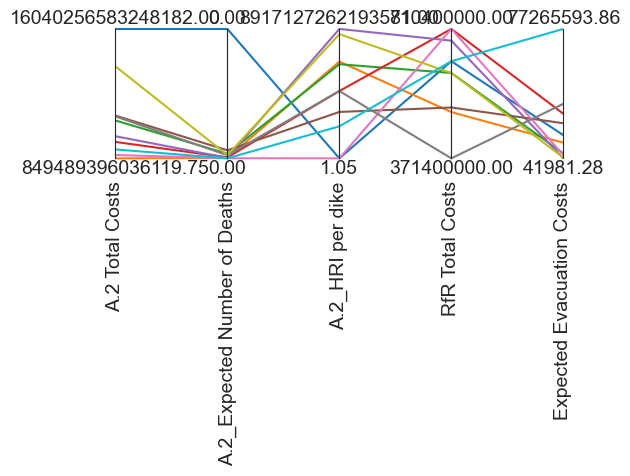

In [195]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

plt.show()

In [196]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

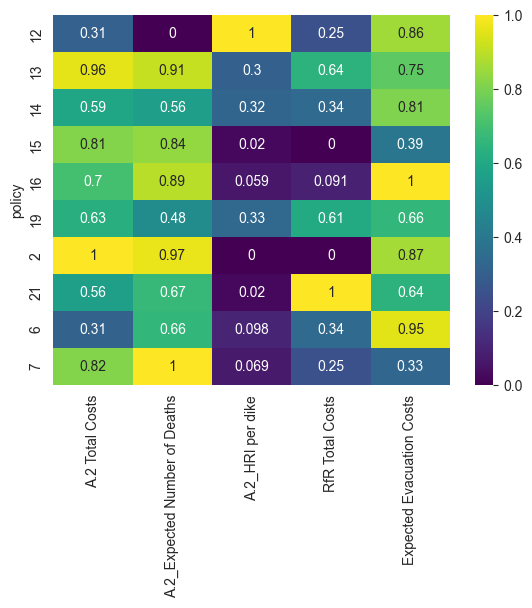

In [197]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret multi mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [198]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,38,78.196338,10.0,0.960959,348.965241,10.0,0.749630,169.193781,10.0,0.995338,...,1,7,10,9,5,7,2,1320,2,dikesnet
1,15,259.166714,1.5,0.337099,144.588903,1.5,0.021926,310.925640,10.0,0.908777,...,1,7,10,9,5,7,2,1321,2,dikesnet
2,120,273.430270,1.0,0.268396,38.782092,1.5,0.921554,218.409799,10.0,0.472083,...,1,7,10,9,5,7,2,1322,2,dikesnet
3,14,123.161007,10.0,0.510033,181.629066,10.0,0.083253,75.287959,1.5,0.803122,...,1,7,10,9,5,7,2,1323,2,dikesnet
4,108,272.369947,1.0,0.533887,84.745929,10.0,0.988461,272.346413,1.5,0.265616,...,1,7,10,9,5,7,2,1324,2,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,104,265.583869,1.5,0.680659,290.273101,10.0,0.464171,347.960872,10.0,0.873857,...,2,2,3,10,0,9,1,1415,21,dikesnet
996,63,329.073125,1.5,0.786383,110.532556,1.5,0.071529,184.156007,1.0,0.363150,...,2,2,3,10,0,9,1,1416,21,dikesnet
997,102,332.315147,10.0,0.427676,312.192628,1.0,0.863162,164.497174,10.0,0.852936,...,2,2,3,10,0,9,1,1417,21,dikesnet
998,27,89.764953,1.5,0.741989,167.197240,1.0,0.514450,215.469749,1.5,0.059120,...,2,2,3,10,0,9,1,1418,21,dikesnet


In [199]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
2,0,1,0,0,0,1,1,0,0,0,...,0,4,8,1,7,10,9,5,7,2
6,0,0,0,0,0,1,0,0,0,0,...,10,10,9,1,9,5,6,7,4,5
7,0,0,0,0,0,1,1,0,0,0,...,7,4,9,2,5,10,6,1,0,0
12,0,0,0,0,1,0,1,0,0,0,...,2,4,4,10,2,9,4,4,5,6
13,0,1,0,0,0,0,1,0,0,0,...,1,1,2,5,9,6,0,4,1,7
14,0,0,0,1,0,0,0,0,0,0,...,3,6,9,2,8,4,0,2,10,3
15,0,1,0,0,1,0,1,0,0,0,...,2,2,7,3,2,1,6,1,2,1
16,1,0,0,1,0,0,0,0,0,0,...,6,7,2,1,10,1,10,10,8,5
19,0,0,0,0,1,0,1,0,0,0,...,4,2,6,4,5,6,1,4,6,5
21,0,1,0,0,0,0,1,0,0,0,...,2,4,0,2,2,3,10,0,9,1


In [200]:
policies.to_csv("multi-scenario_policies.csv", index=True)


## PRIM Analysis for Robustness of Multi-Scenario Policies
In the following code, a PRIM analysis is conducted on the policies selected from the multi-scenario MORDM. This helps identify which uncertainty conditions lead to poor performance, such as high costs or low resilience. It allows us to test whether the most robust policies remain effective under extreme scenarios, supporting more reliable and adaptive long-term planning. It is conducted in the same way as the first one.

In [201]:
# lees de CSV in met de gevonden policies vanuit de MORDM
policies_multiscenario = pd.read_csv("multi-scenario_policies.csv")

# zet elke rij om in een Policy-object
multiscenario_policies = [
    Policy(f"policy_{idx}", **row.to_dict())
    for idx, row in policies_multiscenario.iterrows()
]


In [202]:
if __name__ == "__main__":
    # Load the model for the selected problem formulation (here: problem 3)
    model, _ = get_model_for_problem_formulation(3)

    # Load the robust policies identified from the multi-scenario MORDM
    # These were previously saved to a CSV file
    df_pols = pd.read_csv("multi-scenario_policies.csv")

    # Define number of scenarios for robustness testing
    scenarios = 1000

    # Use the previously selected robust policies from multi-scenario MORDM
    policies = multiscenario_policies  # This variable should contain Policy objects

    # Run the experiment to evaluate the robustness of these policies
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=policies)

    # Unpack results into experiments and outcomes
    experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments

100%|████████████████████████████████████| 10000/10000 [28:19<00:00,  5.89it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [203]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,4,126.914711,1.0,0.610944,104.214513,1.0,0.152840,221.293168,1.0,0.701469,...,1,7,10,9,5,7,2,1420,policy_0,dikesnet
1,95,102.713845,1.0,0.908125,146.338212,10.0,0.748822,163.231450,1.0,0.895925,...,1,7,10,9,5,7,2,1421,policy_0,dikesnet
2,48,196.502213,10.0,0.281535,145.779910,1.5,0.279512,227.278659,1.0,0.515739,...,1,7,10,9,5,7,2,1422,policy_0,dikesnet
3,66,299.973882,1.0,0.999546,47.119315,1.0,0.253871,330.122328,10.0,0.068280,...,1,7,10,9,5,7,2,1423,policy_0,dikesnet
4,49,269.937842,1.0,0.277133,35.552301,1.0,0.358604,97.229120,10.0,0.864061,...,1,7,10,9,5,7,2,1424,policy_0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,42,172.061942,1.0,0.598894,304.699733,10.0,0.897573,342.777988,10.0,0.695152,...,2,2,3,10,0,9,1,2415,policy_9,dikesnet
9996,22,65.301853,1.5,0.099214,83.391325,1.5,0.784377,206.256158,10.0,0.931978,...,2,2,3,10,0,9,1,2416,policy_9,dikesnet
9997,84,184.706498,1.5,0.302911,185.928602,1.5,0.793044,189.088316,1.5,0.901319,...,2,2,3,10,0,9,1,2417,policy_9,dikesnet
9998,84,187.465153,1.0,0.987872,34.315130,10.0,0.172603,303.112491,1.0,0.783495,...,2,2,3,10,0,9,1,2418,policy_9,dikesnet


In [204]:
results_per_policy = {}

hri_baseline=baseline_outcomes["A.2_HRI per dike"]
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
cost_baseline=baseline_outcomes["A.2 Total Costs"]
cost_total = outcomes["A.2 Total Costs"] # (N,)
cost_q75 = np.percentile(cost_baseline, 75)
target_cost = cost_total >= cost_q75


        # ---- 2.3 Combineer tot één worst-case target ----
y = target_hri | target_cost
y


array([ True,  True,  True, ...,  True,  True,  True], shape=(10000,))

In [205]:
# === PRIM Analysis for Each Robust Policy ===

# This dictionary will store the PRIM results per policy
results_per_policy = {}

# Iterate over each robust policy obtained from the multi-scenario MORDM
for pol in multiscenario_policies:

    pol_name = pol.name

    # Select only the runs associated with this policy
    mask_pol = experiments["policy"] == pol_name
    X_pol = experiments.loc[mask_pol, [u.name for u in model.uncertainties]]
    y_pol = y[mask_pol]  # Target variable (e.g., True if performance is bad)

    # Print basic information for verification
    print(f"Policy {pol_name!r}: {len(X_pol)} runs (y=True: {y_pol.sum()}, y=False: {len(y_pol) - y_pol.sum()})")

    # Skip policies without matching experiments
    if len(X_pol) == 0:
        print("  → No runs found for this policy, skipping.")
        continue

    # Ensure target is boolean (required for PRIM)
    if not (y_pol.dtype == bool):
        y_pol = y_pol.astype(bool)

    # Skip if target is all True or all False (PRIM requires variation)
    if y_pol.sum() == 0 or y_pol.sum() == len(y_pol):
        print("  → y contains only one class (True or False), skipping.")
        continue

    # === Run PRIM ===
    prim_alg = prim.Prim(
        X_pol,              # input: uncertainty parameters for this policy
        y_pol,              # target: where policy fails (e.g., high regret)
        threshold=0.6,      # density threshold for box selection
        peel_alpha=0.05,    # how aggressively to peel data
        mass_min=0.1        # minimum fraction of data in a box
    )

    # Find the most relevant box (region of concern)
    box = prim_alg.find_box()

    # Display box summary in console
    box.inspect()
    # Optional: box.show_tradeoff() to plot performance vs. coverage

    # Save the results for this policy for later comparison
    results_per_policy[pol_name] = {
        "prim_alg": prim_alg,
        "selected_box": box,
        "trajectory": box.peeling_trajectory,
    }

Policy 'policy_0': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_1': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_2': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_3': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_4': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_5': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_6': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_7': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or False), skipping.
Policy 'policy_8': 1000 runs (y=True: 1000, y=False: 0)
  → y contains only one class (True or F

In [208]:
# === Step 1: Extract names of all uncertainty parameters ===
cols_unc = [u.name for u in model.uncertainties]

# === Step 2: Determine global min/max ranges for each numeric uncertainty ===
global_ranges = {}  # dictionary to store min/max per variable

for var in cols_unc:
    ser = experiments[var]  # get the column for this uncertainty

    if is_numeric_dtype(ser):
        # If it's numeric (float or int), store its min and max
        lo = ser.min()
        hi = ser.max()
        global_ranges[var] = (lo, hi)
    else:
        # Skip categorical variables for range computation
        # Optionally print the set of categories if available
        cats = ser.cat.categories if hasattr(ser.dtype, "categories") else None
        print(f"  → Skipping categorical variable {var!r} (dtype={ser.dtype})")

# === Step 3: Print all global ranges for manual verification ===
print("\n=== Global Uncertainty Ranges (Numerical Only) ===")
for var, (lo, hi) in global_ranges.items():
    print(f"{var:30s}  glob_min = {lo:8.3f},  glob_max = {hi:8.3f}")

  → Skipping categorical variable 'discount rate 0' (dtype=category)
  → Skipping categorical variable 'discount rate 1' (dtype=category)
  → Skipping categorical variable 'discount rate 2' (dtype=category)
  → Skipping categorical variable 'A.1_Brate' (dtype=category)
  → Skipping categorical variable 'A.2_Brate' (dtype=category)
  → Skipping categorical variable 'A.3_Brate' (dtype=category)
  → Skipping categorical variable 'A.4_Brate' (dtype=category)
  → Skipping categorical variable 'A.5_Brate' (dtype=category)

=== Global Uncertainty Ranges (Numerical Only) ===
A.0_ID flood wave shape         glob_min =    0.000,  glob_max =  132.000
A.1_Bmax                        glob_min =   30.235,  glob_max =  349.723
A.1_pfail                       glob_min =    0.000,  glob_max =    1.000
A.2_Bmax                        glob_min =   30.284,  glob_max =  349.881
A.2_pfail                       glob_min =    0.001,  glob_max =    1.000
A.3_Bmax                        glob_min =   30.005,  gl

In [211]:
# === Step 1: Compute overall failure rate for each policy ===
overall = (
    experiments
      .groupby("policy")
      .apply(lambda df: y[df.index].mean())  # average of True values (failures) in y
      .rename("overall_fail_rate")
)

# === Step 2: Extract PRIM box metrics per policy ===
box_info = []
for pol, info in results_per_policy.items():
    box = info["selected_box"]  # the PrimBox for this policy
    box_info.append({
        "policy":   pol,
        "coverage": box.coverage,   # proportion of bad cases captured by box
        "density":  box.density,    # proportion of bad cases inside the box
        "res_dim":  box.res_dim,    # number of restricted dimensions (simplicity)
        "mass":     box.mass        # total share of runs inside the box
    })

# Convert to DataFrame and align on policy
box_df = pd.DataFrame(box_info).set_index("policy")

# === Step 3: Combine overall failure and box info ===
report = pd.concat([overall, box_df], axis=1)

# Convert from fractions to percentages
report["overall_fail_%"] = report["overall_fail_rate"] * 100
report["box_covers_%"]   = report["coverage"] * 100
report["fail_in_box_%"]  = report["density"] * 100

# Select and order final columns for readability
report = report[[
    "overall_fail_%",
    "box_covers_%",
    "fail_in_box_%",
    "res_dim",
    "mass"
]]

# Sort by vulnerability (highest overall failure rate first)
report = report.sort_values("overall_fail_%", ascending=False)

# Round values to one decimal place
report = report.round(1)

# === Final output ===
print(report)


/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_6609/2487240512.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("policy")
/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_6609/2487240512.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: y[df.index].mean())  # average of True values (failures) in y


KeyError: "None of ['policy'] are in the columns"

In [210]:
# names of all levers in the model
lever_names = [lev.name for lev in model.levers]

# pick the policy you want to inspect
pol_name = "cand_1"          # or any other policy name

# show the lever settings for that policy (one row per scenario)
experiments.loc[experiments["policy"] == pol_name, lever_names]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
